<font size="8">Build an ANUGA Model (BAM) </font>

<font size="3">In this notebook, we will:

- set model configuration parameters

- download and preprocess elevation and landcover datasets

    
- Determine water body polygons


- Build the Digital Elevation Model



</font>

<font size="3">This could take some time, depending on model domain size and complexity of the water mask</font>


<font size=6> Step #1a: Set working directory <br> </font>



<font size=5 color='green'> If you are running in Google Colab, when you run the next cell, a pop-up window will appear asking you to grant access to your Google Drive. You must approve or the notebook will not work. <font> <br>



In [1]:
import os
import sys
from pathlib import Path

your_path = Path(os.getcwd() + '/')

mounted_drive = Path(os.path.abspath(os.path.join(your_path, os.pardir)))
path_ancillary = mounted_drive / 'BAM/ancillary'

print('Your working directory is %s' %(mounted_drive))



Your working directory is /Users/alchrist/Documents/GitHub/BAM


<font size=6> Step #1b: Install and import packages. <font> <br>

<font size=5 color='green'> If you are running in Google Colab, this cell should install all Python packages you need for each tutorial. </font> <br>
<font size=5 color='blue'> If you are running on your own computer, the packages were already installed when you installed the conda environment </font>


In [2]:
path_ancillary = mounted_drive / 'ancillary'
path_code = mounted_drive / 'scripts/'
path_templates = mounted_drive /  'templates/'
path_configs = mounted_drive / 'configs/'
sys.path.insert(1,str(path_code))
print(path_code)
print(path_ancillary)

path_examples = mounted_drive / 'examples'
Path(path_examples).mkdir(parents=True, exist_ok=True)

/Users/alchrist/Documents/GitHub/BAM/scripts
/Users/alchrist/Documents/GitHub/BAM/ancillary


In [3]:
import sys
import os
import pandas as pd
import shutil
from datetime import datetime
from string import Template
import fnmatch
import geopandas as gpd
import rasterio
from osgeo import gdal 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import rtree
from scipy import *

import fnmatch
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt

from main_tools import (build_directory,
                       get_extent_parameters,
                       setup_AOI_files, 
                       make_polygons,
                       make_channel_networks,
                       make_model_foundation, 
                       set_boundary_conditions, 
                       make_watermask,
                       more_opening)

/Users/alchrist/Documents/GitHub/BAM/scripts/orinoco_tools.py:42: UserWarning: ShapelyDeprecationWarning
  warnings.warn('ShapelyDeprecationWarning')
/Users/alchrist/Documents/GitHub/BAM/scripts/orinoco_tools.py:43: UserWarning: UserWarning
  warnings.warn('UserWarning')
/opt/anaconda3/envs/orinoco/lib/python3.7/site-packages/pyTMD/spatial.py:80: ImportWarning: h5py not available
  warnings.warn("h5py not available", ImportWarning)
/opt/anaconda3/envs/orinoco/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 88 from PyObject
  return f(*args, **kwds)


<font size=6, color ='black' > Step #2: Set the AOI and working directory  </font>


AOI should match the name of the folder where files will be saved

In [4]:
AOI = 'mekong'

Path((path_examples / AOI)).mkdir(parents=True, exist_ok=True)

skip = False
res = 30 #meters
print('\n')
print('Study area is ' + AOI)
print('Resolution of this setup is %sm' %(res))

working_path,folders = build_directory(path_examples, AOI)
working_path = Path(working_path)
print(working_path)





Study area is mekong
Resolution of this setup is 30m



##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/Users/alchrist/Documents/GitHub/BAM/examples/mekong
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 
#####

In [5]:

ref_res = 10
res = 30

## Set up working directory and build sub folders if needed
print('\n')
print('Study area is ' + AOI)
print('Resolution of this setup is %sm' %(res))
working_path,folders = build_directory(path_examples, AOI)





Study area is mekong
Resolution of this setup is 30m



##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/Users/alchrist/Documents/GitHub/BAM/examples/mekong
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 
#####

<font size='5' color = 'red' > The parameters were saved to a configuration file, we open that here </font>


In [6]:
parameters = pd.read_csv(folders[2] / ('%s_Configuration.csv' %(AOI)))
print(parameters.iloc[0] )

Unnamed: 0                                 0
Unnamed: 0.1                               0
AOI                                   Mekong
area_m2                        91600000000.0
perimeter_m                        1240078.4
RiverOceanBoundary                   11200.0
Discharge                            16000.0
ExtentFile                  Mekong_input.shp
LandcoverMethod                   WorldCover
LandElevMethod                         GLO30
OceanElevMethod                        GEBCO
LowerRiverElevMethod                   plane
UpperRiverElevMethod                 wdpower
WetlandElevMethod                 constant_0
LakeElevMethod                    constant_1
ManningLUT                           default
WetlandClass                            90.0
BEDINTERCEPT_lower                   0.00004
BEDSLOPE_lower                      0.000006
BEDINTERCEPT_upper                   0.00004
BEDSLOPE_upper                      0.000006
WD_LINEARSLOPE_lower                  0.0195
WD_LINEARI

<font size='6' > Step #3: Configuration Parameters </font>


In [7]:
try:
    ref_10m = rasterio.open('%s_GEBCO_%s.tif' %(folders[8] / AOI,res))
except:
    ref_10m,parameters = get_extent_parameters(path_ancillary,AOI,folders,res,parameters)


Text(0.5, 1.0, 'GEBCO Bathymetry resampled to 10m resolution')

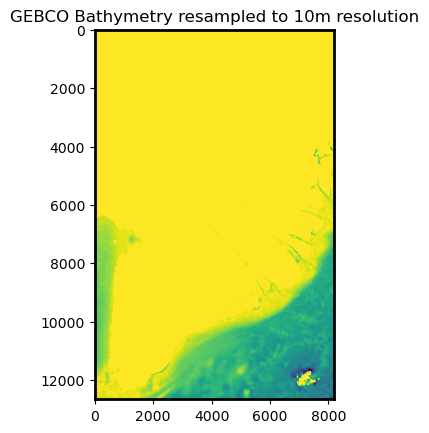

In [8]:
plt.imshow(ref_10m.read(1),vmin=-50,vmax=0)
plt.title('GEBCO Bathymetry resampled to 10m resolution')

<font size='6' > Step #4: Download datasets </font>
<br> Download GEBCO, GLO30, World Cover, and Global Mangrove Maps for the area</font>

In [9]:
ref = setup_AOI_files(your_path,
                    AOI,
                    folders,
                    res,
                    parameters)





##############################################################################################
#################################[Step 2][Setup_AOI_Files]####################################
##############################################################################################

##################### Reference raster is mekong_GEBCO_30.tif
##################### This profile will be used for all future warping
##################### Resolution is 30m

[Step 2][Setup_AOI_Files][Compiling OCEAN elevation dataset] .......

##################### Ocean elevation set with:  GEBCO

[Step 2][Setup_AOI_Files][Compiling LAND elevation dataset] .......

##################### Land elevation set with: GLO30

[Step 2][Setup_AOI_Files][Compiling Landcover Classification Maps] .......

##################### Landcover types based on: WorldCover

[Step 2][Setup_AOI_Files][Loading Global Mangrove Watch ] .......


[Step 3A][Make_Watermask][Delineating wetland areas] ......


[Step 3A][Make_Waterma

<font size='5' color = 'red' > The EPSG coordinate reference system must be is in UTM </font>


<font size='6' > Step #4: Clean the water mask </font> <br>
Clean, filter, smooth the water mask you made in the previous notebook </font>



In [10]:
#ref_10m = rasterio.open('%s/%s_GEBCO_10.tif' %(folders[8],AOI))
watermaskname = make_watermask(path_ancillary, 
                               AOI,
                               folders,
                               parameters,
                               ref_10m,
                               False, 
                               os.path.isfile('%s_watermask_%s.tif' %(folders[8]/AOI,res)))
how_much_opening = 3
if os.path.isfile('%s_watermask_%s.tif' %(folders[8]/AOI,30)) == False:
    more_opening(AOI,folders,watermaskname,how_much_opening,ref_10m,parameters)

    print(watermaskname)





##############################################################################################
#################################[Step 3a][Make_Watermask]####################################
##############################################################################################


[Step 2][Setup_AOI_Files][Compiling Water Masks] .......


[Step 3A][Make_Watermask] Skip .........



In [11]:
EPSG = parameters['EPSG'][0]
ulx = parameters['ulx'][0]
uly = parameters['uly'][0]
lrx = parameters['lrx'][0]
lry = parameters['lry'][0]

In [12]:
if res != 10:
    os.system('gdalwarp -overwrite -tr %s %s %s %s '\
                      ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
                      %(res,res,folders[8]/ ("%s_watermask_10.tif " %(AOI)),folders[8] / ("%s_watermask_%s.tif" %(AOI,res)),ulx,lry,lrx,uly))
    os.system('gdalwarp -overwrite -tr %s %s %s %s '\
                      ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
                      %(res,res,folders[8] / ("%s_landmask_10.tif" %(AOI)),folders[8] / ("%s_landmask_%s.tif" %(AOI,res)),ulx,lry,lrx,uly))


<font size='6' > Step #5: Make polygons of each land cover type <br> </font>
Ocean, lake, river, land


In [13]:
make_polygons(AOI,
            folders,
            parameters,
            ref,
            watermaskname,
            path_templates,
            os.path.isfile('%s_lands_%s.tif' %(folders[8]/AOI,res)))





##############################################################################################
################################[Step 4][Make_Polygons]######################################
##############################################################################################


[Step 4][Make_Polygons][Open land/water mask] .......

##################### Water delineated with mekong_ndvimin_ndwimin_clustered_30

[Step 4][Make_Polygons] SKIP.......



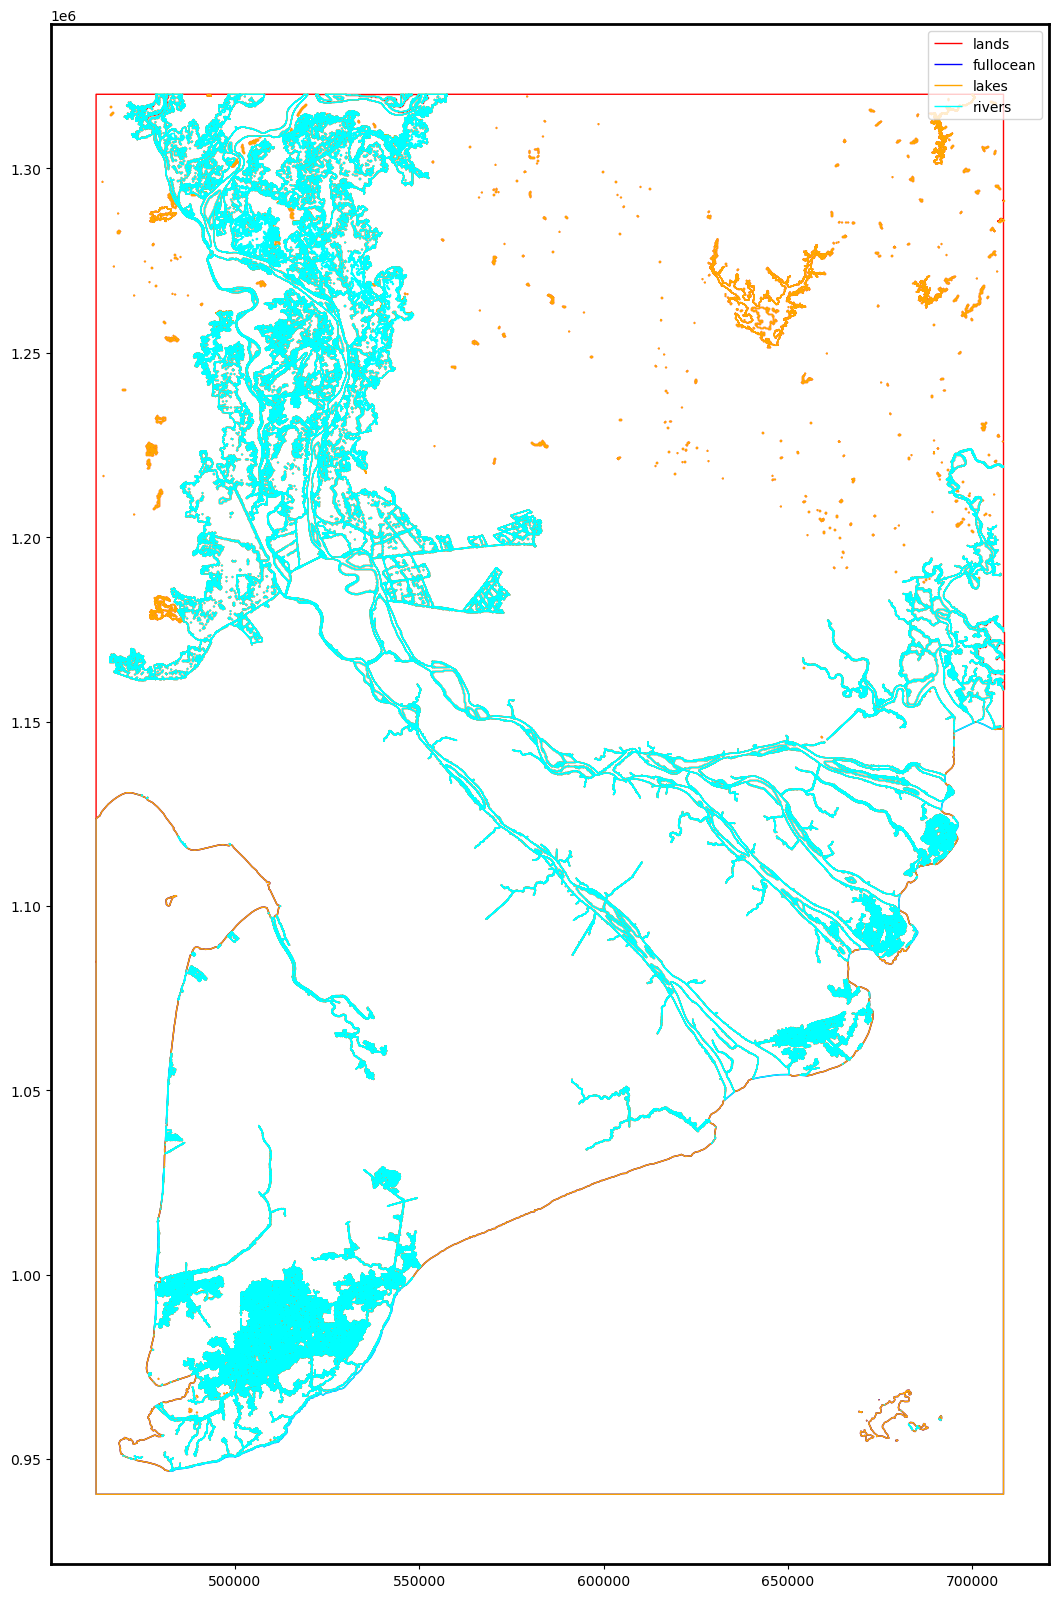

In [14]:
fix,ax = plt.subplots(figsize=(20,20))

colors = ['red','blue','orange','cyan','green']
polys = ['lands','fullocean','lakes','rivers']
i=0
for poly in polys:
    tmp = gpd.read_file([os.path.join(dirpath,f)
            for dirpath,dirnames, files in os.walk(folders[7])
            for f in fnmatch.filter(files,'*%s*.shp' %(poly))][0])
    tmp.geometry.boundary.plot(color=colors[i], edgecolor=colors[i],linewidth = 1,ax=ax,label = poly) #Use your second dataframe
    i=i+1
plt.legend()


<font size='6' > Step #6: Using Orinoco, get distance and width of the river networks</font>


In [19]:
segment_width = 150
pixel_step = int(round(segment_width/res))
if os.path.isfile('%s_river_centerline_%sx%s.shp' %(folders[7]/AOI,res,pixel_step))==False:
    distance,widths = make_channel_networks(folders,
                                      AOI,
                                      ref,
                                      parameters,
                                      pixel_step,False)
centerlines = gpd.read_file('%s_river_centerline_%sx%s.shp' %(folders[7]/AOI,res,pixel_step))


<AxesSubplot:>

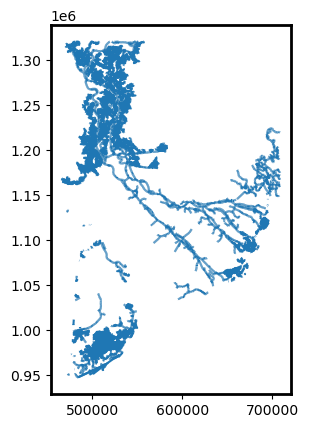

In [20]:
centerlines.plot()

<font size='6' > Step #6: Clean up temporary files </font> <br>


In [22]:
cleanup = True 
if cleanup == True:
    print('Cleaning up temporary files')
    try:shutil.rmtree(folders[1])
    except:''


Cleaning up temporary files


<font size=5 color='red'> Done building DEM and other ancillary files. Move on to the next notebook 3_GetBoundaries.ipynb </font>
